# Projet Fraude bancaire : Création des modèles

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from sklearn.metrics import *
import scikitplot as skplt
from dask_ml.preprocessing import StandardScaler

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [2]:
os.getcwd()

'/home/elisa/Documents/M2_SISE/BigDataMining/Projet_Fraude'

## I. Importation des dataframes
Ici, nous directement les fichiers au format dask à partir d'un format parquet. Ils ont déjà été pré-traités en amont.

In [3]:
# Dataframe d’apprentissage
dfTrain = dd.read_parquet("dfTrain_parquet")
dfTrain.head()

,FlagImpaye,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,0,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,0,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,0,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,0,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


In [4]:
# Dataframe de test
dfTest = dd.read_parquet("dfTest_parquet")
dfTest.head()

,FlagImpaye,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
3899362,0,60.00,302,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899363,0,25.00,547,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899364,0,32.00,152,0.000000,0.000000,0.000000,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0
3899365,0,20.88,393,0.007590,0.182221,0.002092,45.142680,34.118277,4,1,0.573461,0.998206,1.539155,71.51,1,0,0
3899366,0,20.21,152,0.018994,-1.024399,0.005682,45.368313,52.076034,0,1,4.000000,4.000000,4.000000,0.00,1,0,0


In [5]:
# Dataframe d’apprentissage avec sur-échantillonnage SMOTE
dfTrain_SMOTE = dd.read_parquet("dfTrain_SMOTE_parquet")
dfTrain_SMOTE.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3,FlagImpaye
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0,0


## II. Définir la variable cible (y) et les variables explicatives (X)

In [6]:
# Définir la variable cible 
yTrain = dfTrain["FlagImpaye"]
yTrain_SMOTE = dfTrain_SMOTE["FlagImpaye"]
yTest = dfTest["FlagImpaye"]

In [7]:
# Définir les variables explicatives 
XTrain = dfTrain.drop(["FlagImpaye"], axis = "columns")
XTrain_SMOTE = dfTrain_SMOTE.drop(["FlagImpaye"], axis = "columns")
XTest = dfTest.drop(["FlagImpaye"], axis = "columns")

## III. Centrer-réduire les données

In [8]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [9]:
# Centrer-réduire les dataframe d'apprentissage
XTrain_scale = scaler.fit_transform(XTrain)
XTrain_SMOTE_scale = scaler.transform(XTrain_SMOTE)

XTrain_scale.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,-0.030212,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,-1.556786,-0.062428,-0.023797
1,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,0.162138,0.818043,-0.043812,4.975724,-1.945875,-0.301229,-0.451325,0.038808,-1.556786,-0.062428,-0.023797
2,-0.022127,1.008573,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,-1.556786,-0.062428,-0.023797
3,-0.057565,-0.272152,-0.084590,-0.239505,-0.275801,1.172099,0.906727,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,0.642349,-0.062428,-0.023797
4,-0.347310,1.008573,-0.084434,0.637044,-0.273204,0.104780,0.818043,-0.043812,-0.194165,-1.757421,-0.301229,-0.451325,0.702346,-1.556786,-0.062428,-0.023797


## IV. Création des modèles 

In [10]:
def Calcul_CA(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable CA
    dfmerge["CA"] = dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "CA"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "CA"] = 0.8 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "CA"] = 1 - np.exp(1/dfmerge["Montant"])
    
    # Calcul du CA_total
    CA_total = dfmerge["CA"].sum()
    
    return CA_total

In [11]:
# Création de la fonction de déploiement d'un modèle sur les données de test

def deploiement(modele, XTest, yTest, scale, features):
    XTest_ = XTest
    
    if scale == True:
        XTest = scaler.transform(XTest) # scaler a été entrainé sur les données d'apprentissage
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    fichier = open(modele, "rb")
    mdl = pickle.load(fichier)
    fichier.close()
    
    # Affichage du modèle 
    print('Modèle :\n', mdl)
    print("-------------------------------------------------------")
    # Prédiction
    Ypred = delayed(mdl.predict)(XTest).compute()
    # Prédiction des scores
    Yscore = delayed(mdl.predict_proba)(XTest).compute()
    
    # Taux de reconnaissance
    acc = delayed(accuracy_score)(yTest, Ypred).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(yTest, Ypred)
    cr = delayed(classification_report)(yTest, Ypred)
    auc = delayed(roc_auc_score)(yTest, Ypred)
    
    # Calucl du rappel et de la précision
    rappel = delayed(recall_score)(yTest, Ypred).compute()
    precision = delayed(precision_score)(yTest, Ypred).compute()

    print('Estimateurs :\n', cr.compute())
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm.compute())
    print("-------------------------------------------------------")
    AUC = auc.compute()
    print('Auc Score :\n', AUC)
    print("-------------------------------------------------------")
    
    # BONUS :  Calcul du chiffre d'affaire
    CA_total = Calcul_CA(Montant = XTest_["Montant"].compute(), yReel = yTest.compute(), yPred = Ypred)
    print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
    
    if features == True :
        print("-------------------------------------------------------")
        # Importance des variables
        print("Importance des variables :")
        importances = pd.Series(mdl.feature_importances_, index = XTest.columns)
        sorted_importances = importances.sort_values()
        sorted_importances.plot(kind='barh', color='lightgreen')
        plt.show()
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(yTest, Yscore, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(yTest, Yscore, classes_to_plot = 1, plot_micro = False)
    
    return CA_total, AUC, rappel, precision, acc

## V. Algorithmes de régression logistique

### -------- Algorithme n°1 : Régression logistique "simple" --------
Régression logistique "simple" sur les données centrées-réduites.

### a. Création, entrainement et exportation du modele

In [12]:
# Instanciation 
clf = LogisticRegression(random_state=0)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_scale, yTrain)

In [13]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(random_state=0)


In [14]:
# Exportation du modèle 
f = open("modele1.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.94      0.67      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.97      0.83      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740582    255]
 [  2197   4376]]
-------------------------------------------------------
Auc Score :
 0.8327048181010831
-------------------------------------------------------
Chiffre d'affaire = 45836958.17 euros
-------------------------------------------------------


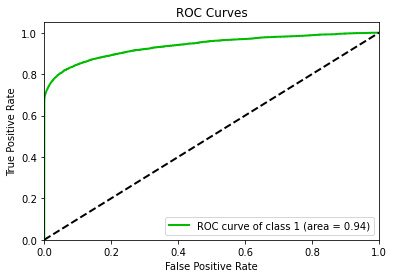

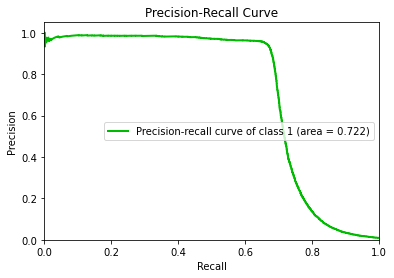

In [84]:
dep1 = deploiement(modele = "modele1.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

### -------- Algorithme n°2 : Régression logistique avec le solveur 'saga' --------
Régression logistique avec le solveur 'saga', recommandé pour les grands jeux de données.

### a. Création, entrainement et exportation du modele

In [16]:
# Instanciation 
clf = LogisticRegression(random_state=0, solver='saga')

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_scale, yTrain)

In [17]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# Exportation du modèle 
f = open("modele2.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.95      0.66      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.97      0.83      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740602    235]
 [  2220   4353]]
-------------------------------------------------------
Auc Score :
 0.8309687347251999
-------------------------------------------------------
Chiffre d'affaire = 45841059.47 euros
-------------------------------------------------------


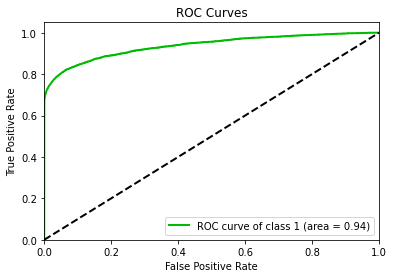

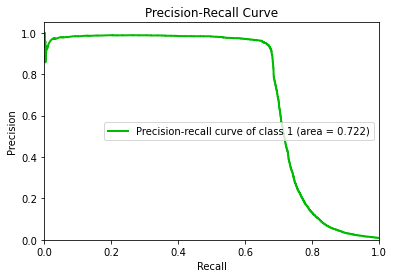

In [19]:
dep2 = deploiement(modele = "modele2.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

### -------- Algorithme n°3 : Régression logistique LASSO --------
Régression logistique LASSO avec le paramètre penalty = 'l1' en utilisant le solveur 'saga'.

### a. Création, entrainement et exportation du modele

In [20]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', C=0.1)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_scale, yTrain)

In [21]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
# Exportation du modèle 
f = open("modele3.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.95      0.66      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.97      0.83      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740603    234]
 [  2220   4353]]
-------------------------------------------------------
Auc Score :
 0.8309694096374951
-------------------------------------------------------
Chiffre d'affaire = 45844719.47 euros
-------------------------------------------------------


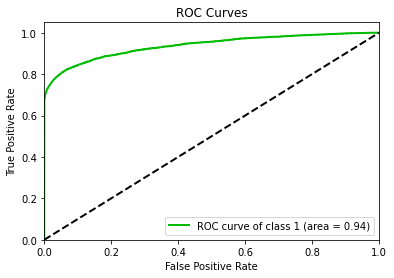

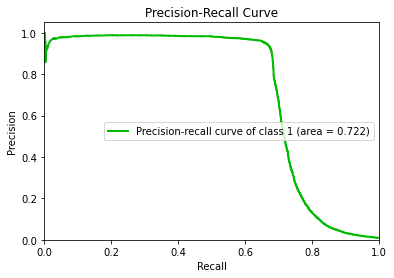

In [23]:
dep3 = deploiement(modele = "modele3.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

### -------- Algorithme n°4 : Régression logistique RIDGE --------¶
Régression logistique RIDGE avec le paramètre penalty = 'l2' en utilisant le solveur 'saga'.

### a. Création, entrainement et exportation du modele

In [24]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='l2', solver='saga', C=0.1)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_scale, yTrain)

In [25]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.1, random_state=0, solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
# Exportation du modèle 
f = open("modele4.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.1, random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.95      0.66      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.97      0.83      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740602    235]
 [  2220   4353]]
-------------------------------------------------------
Auc Score :
 0.8309687347251999
-------------------------------------------------------
Chiffre d'affaire = 45841059.47 euros
-------------------------------------------------------


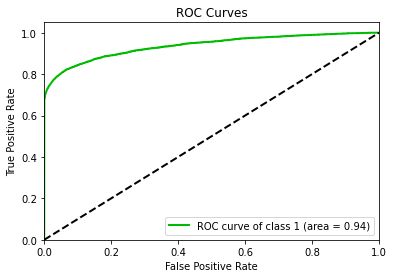

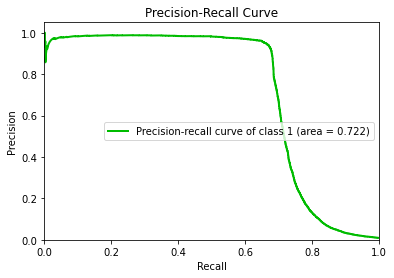

In [27]:
dep4 = deploiement(modele = "modele4.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

### -------- Algorithme n°5 : Régression logistique ELASTICNET --------¶
Régression logistique ELASTICNET en basculant le paramètre penalty = 'elasticnet' avec un l1_ratio = 0.5 pour ne favoriser ni RIDGE, ni LASSO.

### a. Création, entrainement et exportation du modele

In [28]:
# Instanciation 
clf = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01, max_iter=100)

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_scale, yTrain)

In [29]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=0,
                   solver='saga')


/home/elisa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
# Exportation du modèle 
f = open("modele5.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet', random_state=0,
                   solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.95      0.66      0.78      6573

    accuracy                           1.00    747410
   macro avg       0.97      0.83      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740602    235]
 [  2220   4353]]
-------------------------------------------------------
Auc Score :
 0.8309687347251999
-------------------------------------------------------
Chiffre d'affaire = 45844667.27 euros
-------------------------------------------------------


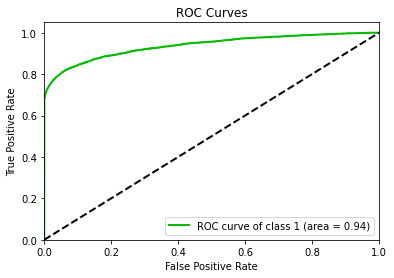

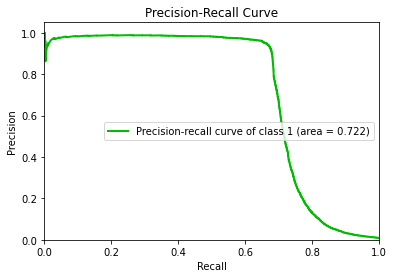

In [31]:
dep5 = deploiement(modele = "modele5.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

### -------- Algorithme n°6 : Régression logistique 'saga' sur données SMOTE --------

### a. Création, entrainement et exportation du modele

In [34]:
# Instanciation 
clf = LogisticRegression(random_state=0, solver='saga')

# Structure de l'entrainement
delayed_fit = delayed(clf.fit)(XTrain_SMOTE_scale, yTrain_SMOTE)

In [35]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

LogisticRegression(random_state=0, solver='saga')


In [36]:
# Exportation du modèle 
f = open("modele6.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    740837
           1       0.12      0.82      0.20      6573

    accuracy                           0.94    747410
   macro avg       0.56      0.88      0.59    747410
weighted avg       0.99      0.94      0.96    747410

-------------------------------------------------------
Matrice de confusion :
 [[700148  40689]
 [  1187   5386]]
-------------------------------------------------------
Auc Score :
 0.8822448681853583
-------------------------------------------------------
Chiffre d'affaire = 44935012.83 euros
-------------------------------------------------------


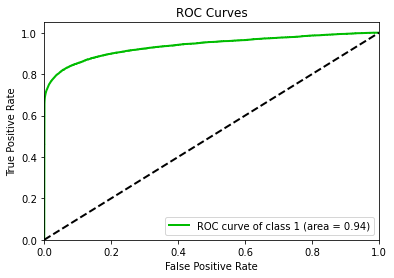

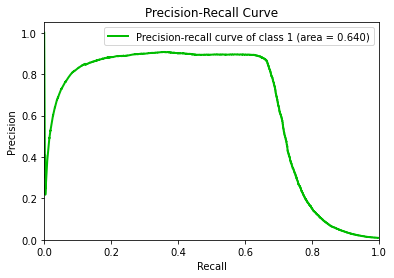

In [37]:
dep6 = deploiement(modele = "modele6.sav", XTest = XTest, yTest = yTest, scale = True, features = False)

## VI. Algorithmes : Arbre de décision, Forêt aléatoire

### -------- Algorithme n°7 : Arbre de décision --------

### a. Création, entrainement et exportation du modele

In [38]:
# Instanciation 
dtree = DecisionTreeClassifier(random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(dtree.fit)(XTrain, yTrain)

In [39]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

DecisionTreeClassifier(random_state=0)


In [40]:
# Exportation du modèle 
f = open("modele7.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 DecisionTreeClassifier(random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.65      0.68      0.66      6573

    accuracy                           0.99    747410
   macro avg       0.82      0.84      0.83    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[738424   2413]
 [  2106   4467]]
-------------------------------------------------------
Auc Score :
 0.8381706150891352
-------------------------------------------------------
Chiffre d'affaire = 45838330.04 euros
-------------------------------------------------------
Importance des variables :


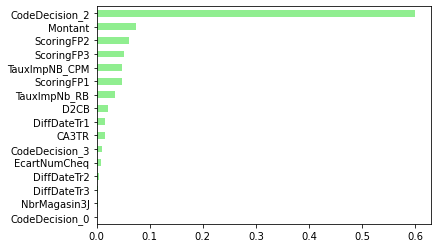

-------------------------------------------------------


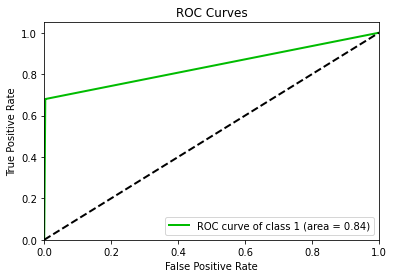

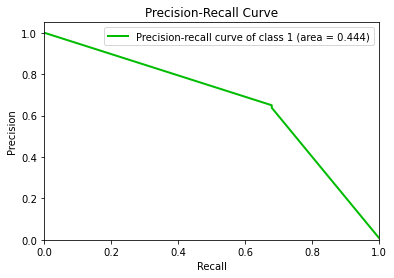

In [41]:
dep7 = deploiement(modele = "modele7.sav", XTest = XTest, yTest = yTest, scale = False, features = True)

### -------- Algorithme n°8 : Forêt aléatoire --------

### a. Création, entrainement et exportation du modele

In [60]:
# Instanciation 
RandomForest = RandomForestClassifier(n_estimators = 10, random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(RandomForest.fit)(XTrain, yTrain)

In [61]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

RandomForestClassifier(n_estimators=10, random_state=0)


In [62]:
# Exportation du modèle 
f = open("modele8.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 RandomForestClassifier(n_estimators=10, random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.98      0.67      0.79      6573

    accuracy                           1.00    747410
   macro avg       0.99      0.83      0.90    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740735    102]
 [  2174   4399]]
-------------------------------------------------------
Auc Score :
 0.8345576613040268
-------------------------------------------------------
Chiffre d'affaire = 45884533.33 euros
-------------------------------------------------------
Importance des variables :


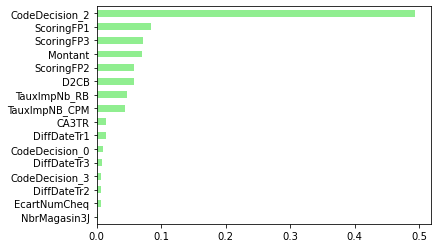

-------------------------------------------------------


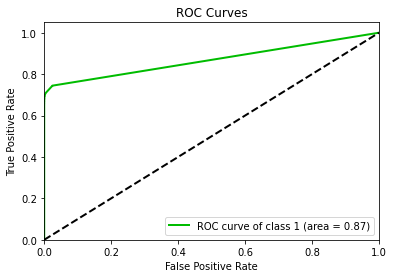

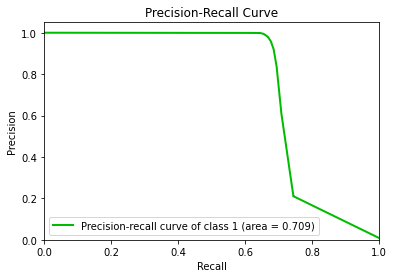

In [63]:
dep8 = deploiement(modele = "modele8.sav", XTest = XTest, yTest = yTest, scale = False, features = True)

### -------- Algorithme n°9 : Arbre de décision + AdaBoost --------

### a. Création, entrainement et exportation du modele

In [46]:
# Instanciation 
dtree = DecisionTreeClassifier(max_depth = 1, random_state = 0)

AdaBoost = AdaBoostClassifier(base_estimator = dtree, n_estimators = 10, random_state = 0)

# Structure de l'entrainement
delayed_fit = delayed(AdaBoost.fit)(XTrain, yTrain)

In [47]:
# Création du modèle entrainé 
model_fit = delayed_fit.compute()
print(model_fit)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=0),
                   n_estimators=10, random_state=0)


In [48]:
# Exportation du modèle 
f = open("modele9.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### b. Déploiement du modèle

-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       1.00      0.64      0.78      6573

    accuracy                           1.00    747410
   macro avg       1.00      0.82      0.89    747410
weighted avg       1.00      1.00      1.00    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  2388   4185]]
-------------------------------------------------------
Auc Score :
 0.8183477863989046
-------------------------------------------------------
Chiffre d'affaire = 45889118.4 euros
--------------------------------------------

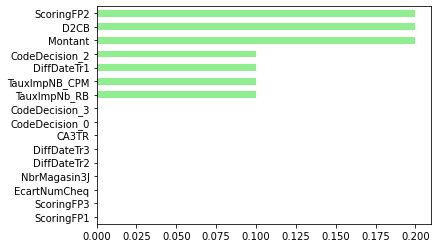

-------------------------------------------------------


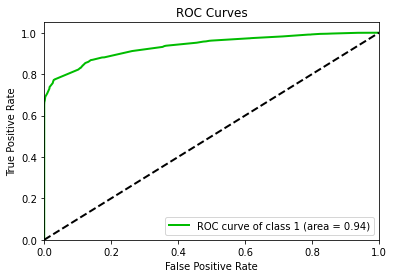

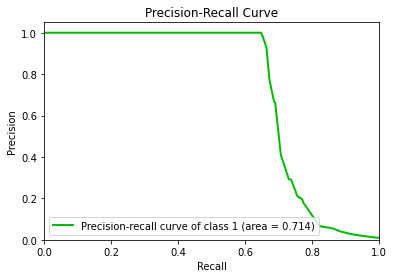

In [49]:
dep9 = deploiement(modele = "modele9.sav", XTest = XTest, yTest = yTest, scale = False, features = True)

## VII. Comparaison des modèles

In [96]:
def Comparaison_modèles(dep, i, ylab, xlab, title):
    depl = [temp[i] for temp in dep]
    plt.plot(depl)
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title) 
    plt.show()

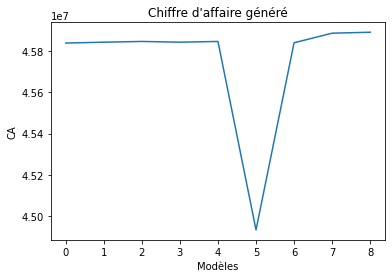

In [97]:
dep = [dep1, dep2, dep3, dep4, dep5, dep6, dep7, dep8, dep9]

Comparaison_modèles(dep = dep, i = 0, ylab = "CA", xlab = "Modèles", 
                    title = "Chiffre d'affaire généré")

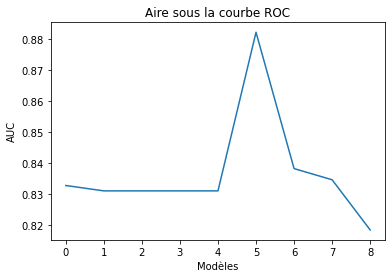

In [87]:
dep = [dep1, dep2, dep3, dep4, dep5, dep6, dep7, dep8, dep9]
Comparaison_modèles(dep = dep, i = 1, ylab = "AUC", xlab = "Modèles", 
                    title = "Aire sous la courbe ROC")

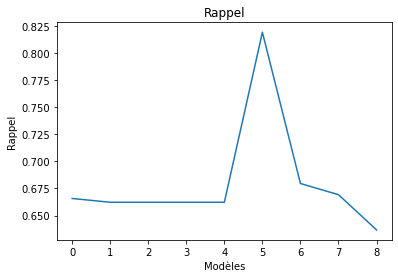

In [93]:
Comparaison_modèles(dep = dep, i = 2, ylab = "Rappel", xlab = "Modèles", 
                    title = "Rappel")

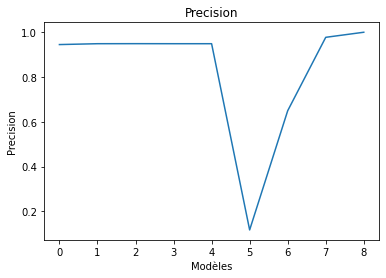

In [86]:
Comparaison_modèles(dep = dep, i = 3, ylab = "Precision", xlab = "Modèles", 
                    title = "Precision")

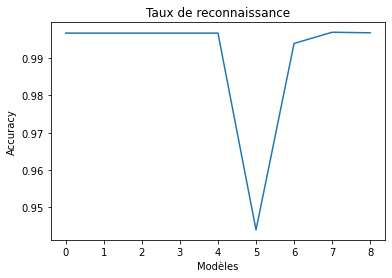

In [88]:
Comparaison_modèles(dep = dep, i = 4, ylab = "Accuracy", xlab = "Modèles", 
                    title = "Taux de reconnaissance")